In [1]:
import numpy as np
import pandas as pd
import spotipy
import matplotlib.pyplot as plt
import plotly.express as px 
import re

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn import metrics

### Importing data

In [2]:
features_data = pd.read_csv(r"C:\Users\angel\Desktop\Data Analysis\Ironhack\Song Recommendation Project\Data\first_1000_albums_features")
albums_data = pd.read_csv(r"C:\Users\angel\Desktop\Data Analysis\Ironhack\Song Recommendation Project\Data\rym_clean1.csv")
genre_data = pd.read_csv(r"C:\Users\angel\Desktop\Data Analysis\Ironhack\Song Recommendation Project\Data\spotify_data\data_w_genres.csv")
new_data = pd.read_csv(r"C:\Users\angel\Desktop\Data Analysis\Ironhack\Song Recommendation Project\Data\spotify_data\data_by_genres.csv")


features_data = features_data.drop(columns=["Unnamed: 0", "type", "uri", "id", "analysis_url", "track_href"], axis=1)
albums_data = albums_data.drop(columns=["Unnamed: 0", "position", "release_type", "review_count"], axis=1)
genre_data.columns = genre_data.columns.str.replace("artists", "artist")
display(features_data,albums_data,genre_data,new_data)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,album,song name,artist
0,0.305,0.872,2,-7.313,1,0.0503,0.007860,0.80000,0.2610,0.648,167.959,287880,4,OK Computer,Airbag,Radiohead
1,0.251,0.848,5,-6.501,1,0.0579,0.037700,0.00591,0.0545,0.207,163.709,387213,4,OK Computer,Paranoid Android,Radiohead
2,0.312,0.595,0,-8.919,1,0.0298,0.048400,0.00139,0.1030,0.337,150.502,267693,3,OK Computer,Subterranean Homesick Alien,Radiohead
3,0.293,0.276,4,-11.357,0,0.0349,0.224000,0.12200,0.1670,0.195,121.603,267187,4,OK Computer,Exit Music (For A Film),Radiohead
4,0.351,0.676,9,-9.017,1,0.0313,0.000121,0.11300,0.1800,0.143,102.460,299560,4,OK Computer,Let Down,Radiohead
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11179,0.470,0.700,5,-8.600,0,0.0425,0.782000,0.24400,0.2550,0.446,167.749,300733,4,Trouble Will Find Me,Humiliation,The National
11180,0.502,0.656,9,-7.340,1,0.0435,0.799000,0.10900,0.0895,0.275,110.157,276200,4,Trouble Will Find Me,Pink Rabbits,The National
11181,0.488,0.514,8,-12.021,1,0.0309,0.794000,0.00508,0.0979,0.104,114.079,253454,5,Trouble Will Find Me,Hard to Find,The National
11182,0.612,0.876,5,-7.668,0,0.1100,0.220000,0.39900,0.0863,0.677,123.866,793200,4,Expensive Shit,Expensive Shit,Fela Kuti


,release_name,artist_name,release_date,primary_genres,secondary_genres,descriptors,avg_rating,rating_count
0,OK Computer,Radiohead,1997-06-16,"Alternative Rock, Art Rock",NaN,"melancholic, anxious, futuristic, malevocals, ...",4.24,74027
1,Kid A,Radiohead,2000-10-03,"Art Rock, Experimental Rock, Electronic","Ambient, Electronic, IDM","cold, melancholic, futuristic, anxious, atmosp...",4.23,61658
2,The Dark Side of the Moon,Pink Floyd,1973-03-23,"Art Rock, Progressive Rock","Psychedelic Rock, Space Rock","philosophical, atmospheric, introspective, exi...",4.21,60192
3,Loveless,My Bloody Valentine,1991-11-11,"Shoegaze, Noise Pop","Dream Pop, Neo-Psychedelia","noisy, ethereal, atmospheric, romantic, love, ...",4.24,53174
4,My Beautiful Dark Twisted Fantasy,Kanye West,2010-11-22,"Pop Rap, Hip Hop",Art Pop,"epic, boastful, passionate, sampling, hedonist...",4.09,52149
...,...,...,...,...,...,...,...,...
4995,Copia,Eluvium,2007-02-20,Ambient,"Modern Classical, Post-Minimalism","instrumental, atmospheric, bittersweet, sentim...",3.44,2171
4996,Let Mortal Heroes Sing Your Fame,Summoning,2001-10-31,"Atmospheric Black Metal, Symphonic Black Metal",Dungeon Synth,"fantasy, epic, triumphant, melodic, atmospheri...",3.73,2170
4997,Dangerous Days,Perturbator,2014-06-17,"Darksynth, Horror Synth, Synthwave",Electro-Industrial,"futuristic, ominous, sciencefiction, atmospher...",3.50,2170
4998,Third Ear Band,Third Ear Band,1970-06-01,"Progressive Folk, Free Folk","Drone, Free Improvisation","instrumental, ritualistic, hypnotic, atmospher...",3.63,2169


,genres,artist,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
0,['show tunes'],"""Cats"" 1981 Original London Cast",0.590111,0.467222,250318.555556,0.394003,0.011400,0.290833,-14.448000,0.210389,117.518111,0.389500,38.333333,5,1,9
1,[],"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,30.576923,5,1,26
2,[],"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.857143,0,1,7
3,[],"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.851852,0,1,27
4,[],"""Joseph And The Amazing Technicolor Dreamcoat""...",0.510714,0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,43.000000,5,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28675,[],麥志誠,0.512000,0.356000,198773.000000,0.306000,0.008970,0.108000,-10.119000,0.027700,150.049000,0.328000,35.000000,10,1,2
28676,"['c-pop', 'classic cantopop', 'classic mandopo...",黃品源,0.541000,0.578000,293840.000000,0.334000,0.000006,0.067500,-11.974000,0.026700,135.934000,0.243000,48.000000,9,0,2
28677,[],黃國隆,0.785455,0.570818,174582.727273,0.148400,0.000083,0.142191,-21.610091,0.054355,119.586273,0.741273,23.000000,5,1,11
28678,"['chinese indie', 'chinese indie rock']",黑豹,0.381000,0.353000,316160.000000,0.686000,0.000000,0.056800,-9.103000,0.039500,200.341000,0.352000,35.000000,11,1,2


,mode,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,21st century classical,0.979333,0.162883,1.602977e+05,0.071317,0.606834,0.361600,-31.514333,0.040567,75.336500,0.103783,27.833333,6
1,1,432hz,0.494780,0.299333,1.048887e+06,0.450678,0.477762,0.131000,-16.854000,0.076817,120.285667,0.221750,52.500000,5
2,1,8-bit,0.762000,0.712000,1.151770e+05,0.818000,0.876000,0.126000,-9.180000,0.047000,133.444000,0.975000,48.000000,7
3,1,[],0.651417,0.529093,2.328809e+05,0.419146,0.205309,0.218696,-12.288965,0.107872,112.857352,0.513604,20.859882,7
4,1,a cappella,0.676557,0.538961,1.906285e+05,0.316434,0.003003,0.172254,-12.479387,0.082851,112.110362,0.448249,45.820071,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2968,1,zolo,0.222625,0.547082,2.580991e+05,0.610240,0.143872,0.204206,-11.295878,0.061088,125.494919,0.596155,33.778943,9
2969,0,zouglou,0.161000,0.863000,2.063200e+05,0.909000,0.000000,0.108000,-5.985000,0.081300,119.038000,0.845000,58.000000,7
2970,1,zouk,0.263261,0.748889,3.060728e+05,0.622444,0.257227,0.089678,-10.289222,0.038778,101.965222,0.824111,46.666667,5
2971,0,zurich indie,0.993000,0.705667,1.984173e+05,0.172667,0.468633,0.179667,-11.453333,0.348667,91.278000,0.739000,0.000000,7


### Trying to set the conection between the genres and the audio features 

In [3]:
#def extraer_palabras_unicas(columna):
    #palabras_unicas = set()

    #for texto in columna:
        #palabras = re.findall(r"'([^']*)'", texto)
        #palabras_unicas.update([palabra.lower() for palabra in palabras])
        
    #return list(palabras_unicas)

#all_genres = extraer_palabras_unicas(genre_data["genres"])
#all_genres

In [4]:
#for genre in all_genres:
    #genre_data[genre] = genre_data["genres"].apply(lambda x: 1 if genre in x else 0)

### First Clustering

In [5]:
x = features_data[["danceability","energy","key","loudness","mode","speechiness","acousticness","instrumentalness","valence","tempo"]]
scaler = StandardScaler()
x_prep = scaler.fit_transform(x)
pd.DataFrame(x_prep, columns=x.columns)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo
0,-1.003740,0.987720,-0.900690,0.446974,0.713375,-0.395280,-0.838875,1.691627,0.833853,1.566516
1,-1.296614,0.892725,-0.065169,0.610150,0.713375,-0.328014,-0.744714,-0.667603,-0.881915,1.426619
2,-0.965774,-0.108686,-1.457704,0.124240,0.713375,-0.576721,-0.710950,-0.681032,-0.376133,0.991884
3,-1.068823,-1.371334,-0.343676,-0.365689,-1.401786,-0.531582,-0.156842,-0.322701,-0.928603,0.040616
4,-0.754254,0.211924,1.048859,0.104546,0.713375,-0.563445,-0.863295,-0.349440,-1.130915,-0.589514
...,...,...,...,...,...,...,...,...,...,...
11179,-0.108846,0.306919,-0.065169,0.188345,-1.401786,-0.464316,1.603933,0.039759,0.047946,1.559604
11180,0.064709,0.132761,1.048859,0.441548,0.713375,-0.455465,1.657577,-0.361324,-0.617352,-0.336152
11181,-0.011222,-0.429295,0.770352,-0.499124,0.713375,-0.566985,1.641799,-0.670069,-1.282650,-0.207051
11182,0.661304,1.003553,-0.065169,0.375635,-1.401786,0.133111,-0.169464,0.500262,0.946681,0.115107


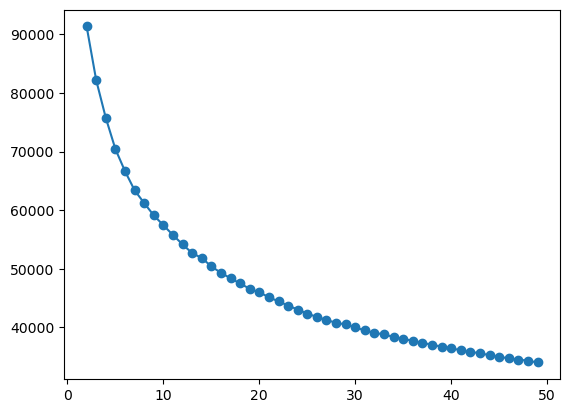

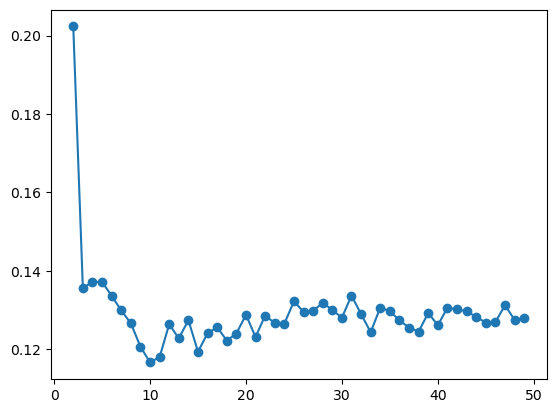

In [6]:
inertia = []
silhouette_scores = []
ranges = range(2,50)

for k in ranges:
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10).fit(x_prep)
    inertia.append(kmeans_model.inertia_)

    silhouette_avg = silhouette_score(x_prep, kmeans_model.labels_)
    silhouette_scores.append(silhouette_avg)

plt.plot(ranges,inertia, marker = "o")
plt.show()

plt.plot(ranges, silhouette_scores, marker="o")

In [7]:
n_clusters = 2

kmeans_model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10).fit(x_prep)

clusters = kmeans_model.predict(x_prep)

s = metrics.silhouette_score(x_prep, clusters)

scaled_df = pd.DataFrame(x_prep, columns=x.columns)
scaled_df['cluster'] = clusters
scaled_df["song_name"] = features_data["song name"]
scaled_df["album"] = features_data["album"]
scaled_df["artist"] = features_data["artist"]
scaled_df

scaled_df.groupby(['cluster'], as_index=False).count().sort_values(['cluster'], ascending=[True]).reset_index(drop=True)

,cluster,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo,song_name,album,artist
0,0,3278,3278,3278,3278,3278,3278,3278,3278,3278,3278,3278,3278,3278
1,1,7906,7906,7906,7906,7906,7906,7906,7906,7906,7906,7906,7906,7906


In [8]:
dbscan_model = DBSCAN(eps=2, min_samples=5)
dbscan_model.fit(x_prep)
dbscan_clusters = dbscan_model.labels_
dbs = metrics.silhouette_score(x_prep, dbscan_clusters)

scaled_df2 = pd.DataFrame(x_prep, columns=x.columns)
scaled_df2['cluster'] = dbscan_clusters
scaled_df2["song_name"] = features_data["song name"]
scaled_df2["album"] = features_data["album"]
scaled_df2["artist"] = features_data["artist"]
scaled_df2.groupby(['cluster'], as_index=False).count().sort_values(['cluster'], ascending=[True]).reset_index(drop=True)

,cluster,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo,song_name,album,artist
0,-1,134,134,134,134,134,134,134,134,134,134,134,134,134
1,0,7321,7321,7321,7321,7321,7321,7321,7321,7321,7321,7321,7321,7321
2,1,3706,3706,3706,3706,3706,3706,3706,3706,3706,3706,3706,3706,3706
3,2,23,23,23,23,23,23,23,23,23,23,23,23,23


In [9]:
gauss_model = GaussianMixture(n_components=2, random_state=42, n_init=10)
gauss_clusters = gauss_model.fit_predict(x_prep)
gsm = metrics.silhouette_score(x_prep, gauss_clusters)
scaled_df3 = pd.DataFrame(x_prep, columns=x.columns)
scaled_df3['cluster'] = gauss_clusters
scaled_df3["song_name"] = features_data["song name"]
scaled_df3["album"] = features_data["album"]
scaled_df3["artist"] = features_data["artist"]
scaled_df3.groupby(['cluster'], as_index=False).count().sort_values(['cluster'], ascending=[True]).reset_index(drop=True)

,cluster,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo,song_name,album,artist
0,0,7370,7370,7370,7370,7370,7370,7370,7370,7370,7370,7370,7370,7370
1,1,3814,3814,3814,3814,3814,3814,3814,3814,3814,3814,3814,3814,3814


In [10]:
print(f"silhouette_score from KMeans: {s}")
print(f"silhouette_score from DBSCAN: {dbs}")
print(f"silhouette_score from Gaussian Mixture: {gsm}")

silhouette_score from KMeans: 0.20234470029037283
silhouette_score from DBSCAN: 0.12802386407915056
silhouette_score from Gaussian Mixture: 0.07744429559556167


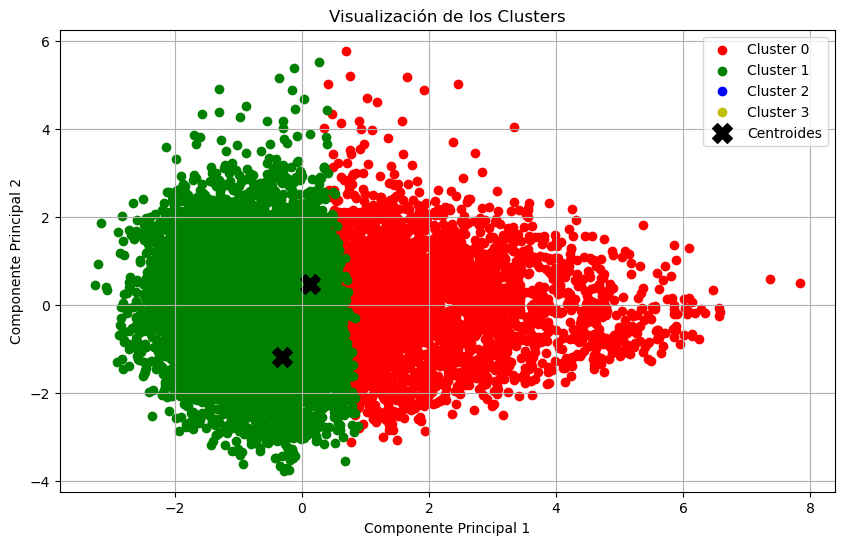

In [11]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x_prep)

pca_df = pd.DataFrame(data=principal_components, columns=['Componente Principal 1', 'Componente Principal 2'])
pca_df = pd.concat([pca_df, scaled_df['cluster']], axis=1)

plt.figure(figsize=(10, 6))
colors = ['r', 'g', 'b', 'y']
for cluster, color in zip(range(4), colors):
    cluster_data = pca_df[pca_df['cluster'] == cluster]
    plt.scatter(cluster_data['Componente Principal 1'], cluster_data['Componente Principal 2'], c=color, label=f'Cluster {cluster}')
centroids = kmeans_model.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, c='black', label='Centroides')

plt.title('Visualización de los Clusters')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True)
plt.show()

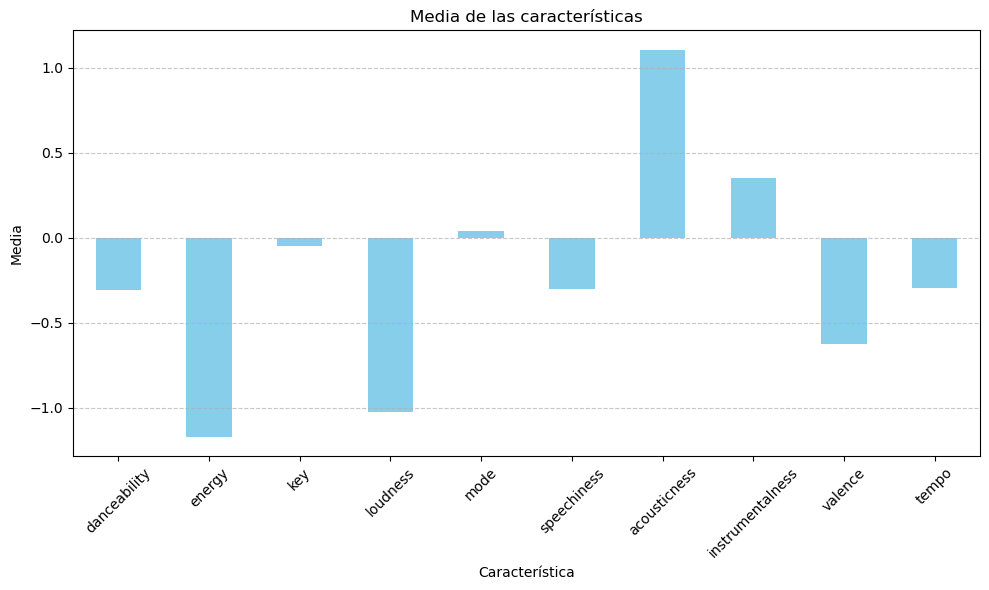

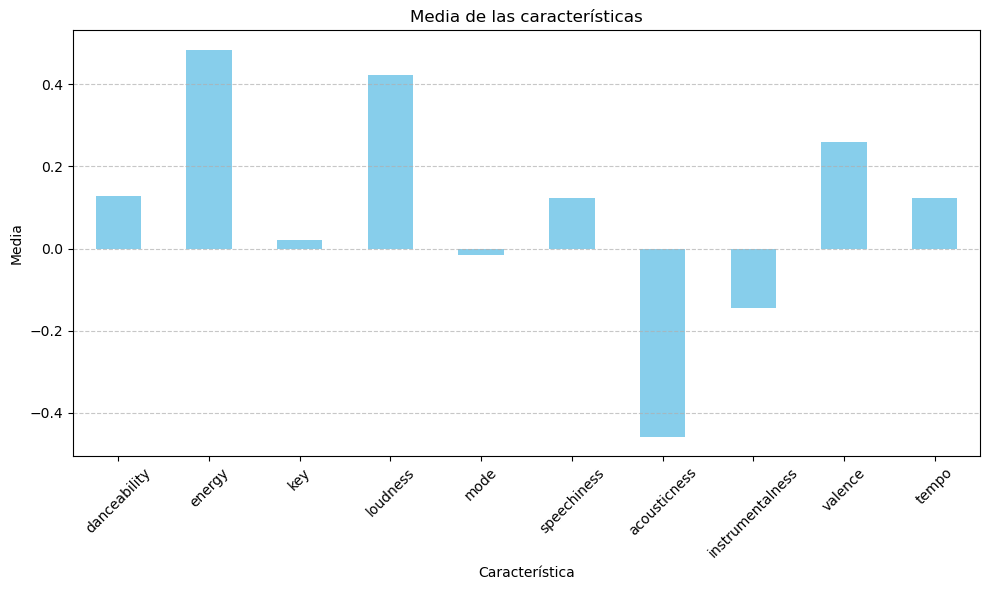

In [12]:
for i in range(n_clusters):
    data = scaled_df[scaled_df["cluster"] == i].drop(columns="cluster", axis=1).describe().T["mean"]
    plt.figure(figsize=(10, 6))
    data.plot(kind='bar', color='skyblue')
    plt.title('Media de las características')
    plt.xlabel('Característica')
    plt.ylabel('Media')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
